# Novel Pose and Expression Synthesis for a Pretrained Avatar

In [64]:
from nha.util.render import create_intrinsics_matrix
import torch
from nha.models.nha_optimizer import NHAOptimizer
from nha.util.general import dict_2_device
import numpy as np
import matplotlib.pyplot as plt

In [60]:
ckpt = "path-to-ckpt.ckpt"
tracking_results="path-to-tracked_flame_params.npz"

In [61]:
avatar = NHAOptimizer.load_from_checkpoint(ckpt).eval().cuda()
tr = np.load(tracking_results)

In [62]:
# Synthesizing novel poses and expressions
@torch.no_grad()
def synthesize_novel_poses_and_expressions(expr = torch.zeros(100, dtype=torch.float),
                                           pose = torch.zeros(15, dtype=torch.float), image_size = (512, 512)):
    
    img_h, img_w = image_size
    track_h, track_w = tr['image_size']
    fx_scale = max(track_h, track_w) * img_w / track_w
    fy_scale = max(track_h, track_w) * img_h / track_h
    cx_scale = img_w
    cy_scale = img_h
    cam_intrinsics = create_intrinsics_matrix(
        fx=tr["K"][0] * fx_scale,
        fy=tr["K"][0] * fy_scale,
        px=tr["K"][1] * cx_scale,
        py=tr["K"][2] * cy_scale,
    ) 

    # creating batch with inputs to avatar
    rest_joint_rots = avatar._flame.get_neutral_joint_rotations()
    default_pose = torch.cat((rest_joint_rots["global"], 
                              rest_joint_rots["neck"], 
                              rest_joint_rots["jaw"], 
                              rest_joint_rots["eyes"],
                              rest_joint_rots["eyes"]
                             ), dim=0).cpu()
    
    batch = dict(
                flame_shape = torch.from_numpy(tr["shape"][None]).float(),
                flame_expr = expr[None],
                flame_pose = (pose+default_pose)[None],
                flame_trans = torch.from_numpy(tr["translation"][[0]]).float(),
                cam_intrinsic=cam_intrinsics[None],
                cam_extrinsic=torch.from_numpy(tr["RT"]).float()[None],
                rgb=torch.zeros(1,3,img_h,img_w))    
    
    batch = dict_2_device(batch, avatar.device)
    
    
    # make prediction
    rgba = avatar.forward(batch, symmetric_rgb_range=False)
    shaded_mesh = avatar.predict_shaded_mesh(batch)
    
    return rgba, shaded_mesh
    
    

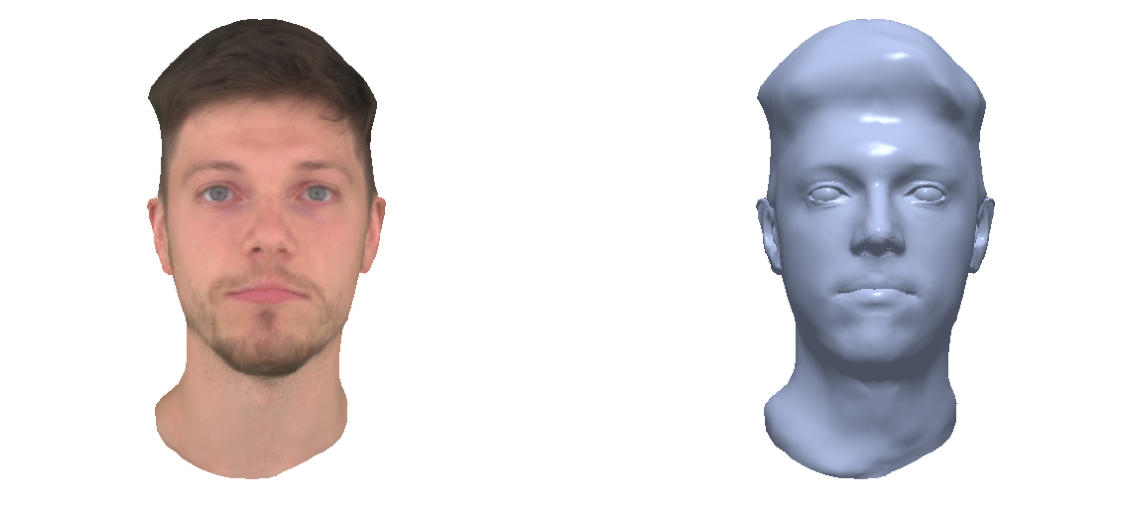

In [63]:
"""
Manipulate the following parameters to control the avatar.
"""

# expression parameters
e0 = 0
e1 = 0
e2 = 0
e3 = 0
e4 = 0

# global rotation
rot0 = 0
rot1 = np.pi
rot2 = 0

# neck rotation
neck0 = 0
neck1 = 0
neck2 = 0

# jaw movement
jaw = 0

expr = torch.zeros(100, dtype=torch.float)
pose = torch.zeros(15, dtype=torch.float)
expr[0] = e0; expr[1] = e1; expr[2] = e2; expr[3] = e3; expr[4] = e4
pose[0] = rot0; pose[1] = rot1;  pose[2] = rot2; pose[3] = neck0;  pose[4] = neck1; pose[5] = neck2; pose[6] = jaw


rgba, shaded_mesh = synthesize_novel_poses_and_expressions(expr=expr, pose=pose, image_size=(512,512))
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
axes[0].imshow(rgba[0,:3].cpu().permute(1,2,0))
axes[1].imshow(shaded_mesh[0, :3].cpu().permute(1,2,0))
[a.axis("off") for a in axes]
plt.show()